# Package

In [1]:
import time
import os
from copy import deepcopy 

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.utils import shuffle, resample
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = (20, 15)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

# Hyperparameters

In [3]:
N_FOLD = 5
EX_PRED = 0

# Data Preparation

## loading

In [4]:
# Load data
l = np.load("./data/CO2_LSTM_T144_I10 min.npz")

# See what's in here
print (l.files)

# get data
rnn_input = l["inputs"]
rnn_label = l["labels"]

MINS = l["mins"]
MAXS = l["maxs"]

LABELMINS = l["labelmins"]
LABELMAXS = l["labelmaxs"]

TIME_STEPS = l["timesteps"]
OUTPUT_SIZE = l["outputsize"]

START_OUTPUT = pd.DatetimeIndex(l["start_output"])
START_INPUT = pd.DatetimeIndex(l["start_input"])
END_OUTPUT = pd.DatetimeIndex(l["end_output"])
END_INPUT = pd.DatetimeIndex(l["end_input"])
INTERVAL = pd.Timedelta(str(l["interval"]))

#EXPLANATION = str(l["explanation"])
EXPLANATION = "CO2_LSTM_bestloss" + "_T" + str(TIME_STEPS) + "_I" + str(l["interval"])

['maxs', 'outputsize', 'labelmins', 'timesteps', 'mins', 'labelmaxs', 'start_output', 'labels', 'explanation', 'inputs', 'interval', 'start_input', 'end_input', 'end_output']


In [5]:
EXPLANATION

'CO2_LSTM_bestloss_T144_I10 min'

## Separating

In [7]:
print("time steps: %d, " % TIME_STEPS, end="")
print("output size: %d" % OUTPUT_SIZE)
print("Number of data: %d" % len(rnn_label))
print("Number of input: %d" % rnn_input[0].shape[1])

time steps: 144, output size: 12
Number of data: 87252
Number of input: 15


In [7]:
N_DATA = len(rnn_label)
RATIO = 0.3
N_TEST = int(np.trunc(N_DATA*RATIO))
FOLD_INTERVAL = int(np.trunc((N_DATA - N_TEST)/(N_FOLD - 1)))

print("%d-fold validation setting" % N_FOLD)
print("Test ratio: %.2f\nNumber of test: %d\nFolding interval: %d" % (RATIO, N_TEST, FOLD_INTERVAL))

5-fold validation setting
Test ratio: 0.30
Number of test: 26175
Folding interval: 15269


In [8]:
rnn_label = np.squeeze(rnn_label)

In [9]:
pred_indexs = []
    
for i in range(N_FOLD):
    pred_indexs.append(FOLD_INTERVAL*i)

In [10]:
pred_inputs = []
pred_labels = []
rnn_inputs = []
rnn_labels = []

pred_input_index = []
pred_label_index = []

i = 0

for pred_index in pred_indexs[:-1]:
    pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
    pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])
    
    pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
    pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])
    
    pred_inputs.append(pred_input)
    pred_labels.append(pred_label)

    rnn_inputs.append(rnn_input)
    rnn_labels.append(rnn_label)
    rnn_inputs[i] = np.delete(rnn_inputs[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    rnn_labels[i] = np.delete(rnn_labels[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    i += 1

pred_index = pred_indexs[-1]
pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])

pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])

pred_inputs.append(pred_input)
pred_labels.append(pred_label)

rnn_inputs.append(rnn_input)
rnn_labels.append(rnn_label)
rnn_inputs[-1] = rnn_inputs[-1][:pred_index]
rnn_labels[-1] = rnn_labels[-1][:pred_index]

In [11]:
for i in range(N_FOLD):
    rnn_inputs[i], rnn_labels[i] = shuffle(rnn_inputs[i], rnn_labels[i])

In [12]:
print("Data is ready.")

Data is ready.


In [13]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

# Training & Plotting

1 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.193750, best: 100000.000
Training Acc: 0.498, Test Acc: 0.492
-36.35353891504902
Epoch:      500/   50000 cost: 1.101932, best: 100000.000
Training Acc: 0.714, Test Acc: 0.570
0.670755741959073
Epoch:     1001/   50000 cost: 1.375566, best: 0.001 *Best value was replaced.
0.670755741959073
Epoch:     1000/   50000 cost: 1.375566, best: 0.001
Training Acc: 0.772, Test Acc: 0.642
0.7171658198119005
Epoch:     1004/   50000 cost: 1.377219, best: 0.001 *Best value was replaced.
0.7171658198119005
Epoch:     1005/   50000 cost: 1.377746, best: 0.001 *Best value was replaced.
0.7171658198119005
Epoch:     1065/   50000 cost: 1.408207, best: 0.001 *Best value was replaced.
0.7171658198119005
Epoch:     1069/   50000 cost: 1.409898, best: 0.001 *Best value was replaced.
0.7171658198119005
Epoch:     1070/   50000 cost: 1.410597, best: 0.001 *Best value was replaced.
0.7171658198119005
Epoch:     1310/   50000 cost

Epoch:    15000/   50000 cost: 6.921018, best: 0.001
Training Acc: 0.838, Test Acc: 0.731
0.7626336372516939
Epoch:    15500/   50000 cost: 7.101918, best: 0.001
Training Acc: 0.834, Test Acc: 0.726
0.7634523858275252
Epoch:    15767/   50000 cost: 7.194639, best: 0.001 *Best value was replaced.
0.7634523858275252
Epoch:    16000/   50000 cost: 7.276828, best: 0.001
Training Acc: 0.842, Test Acc: 0.729
0.758548144594991
Epoch:    16344/   50000 cost: 7.400996, best: 0.001 *Best value was replaced.
0.758548144594991
Epoch:    16500/   50000 cost: 7.460240, best: 0.001
Training Acc: 0.808, Test Acc: 0.674
0.7298184625641299
Epoch:    16545/   50000 cost: 7.479398, best: 0.001 *Best value was replaced.
0.7298184625641299
Epoch:    17000/   50000 cost: 7.640818, best: 0.001
Training Acc: 0.837, Test Acc: 0.705
0.7506116403246729
Epoch:    17500/   50000 cost: 7.817351, best: 0.001
Training Acc: 0.843, Test Acc: 0.713
0.7504556683348708
Epoch:    18000/   50000 cost: 7.988309, best: 0.001
T

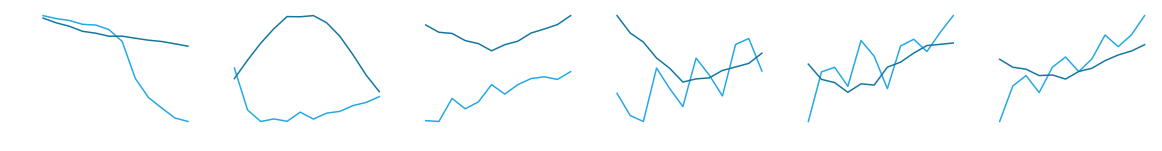

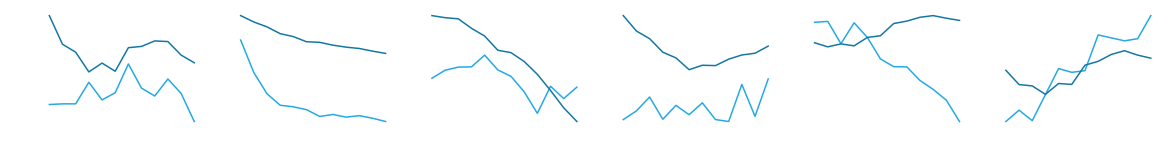

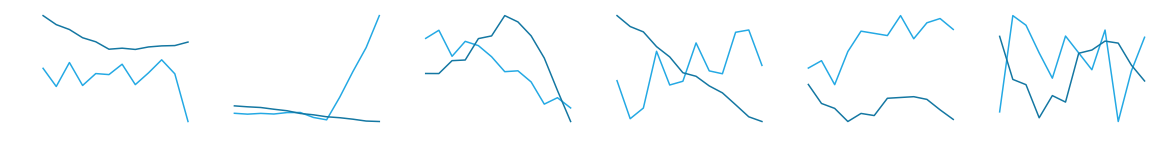

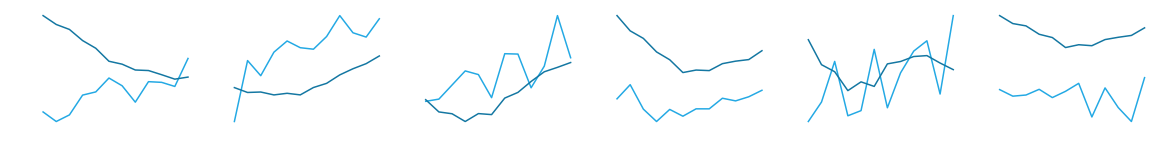

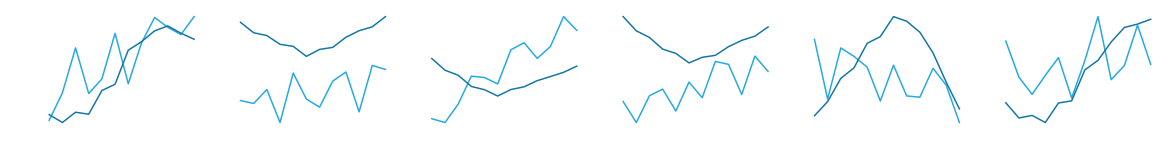

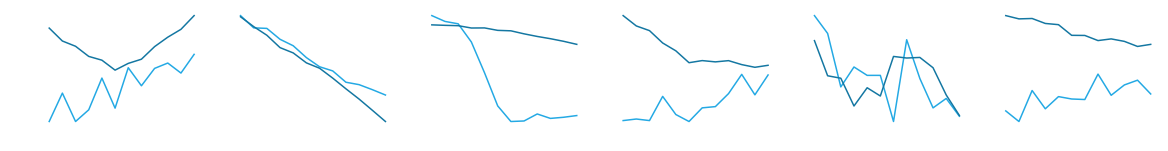

2 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.193433, best: 100000.000
Training Acc: 0.493, Test Acc: 0.494
-95.14348284196892
Epoch:      500/   50000 cost: 1.723213, best: 100000.000
Training Acc: 0.777, Test Acc: 0.720
0.6487225616619834
Epoch:     1001/   50000 cost: 2.127705, best: 0.001 *Best value was replaced.
0.6487225616619834
Epoch:     1000/   50000 cost: 2.127705, best: 0.001
Training Acc: 0.808, Test Acc: 0.744
0.6823911577529769
Epoch:     1010/   50000 cost: 2.134489, best: 0.001 *Best value was replaced.
0.6823911577529769
Epoch:     1011/   50000 cost: 2.135557, best: 0.001 *Best value was replaced.
0.6823911577529769
Epoch:     1014/   50000 cost: 2.138251, best: 0.001 *Best value was replaced.
0.6823911577529769
Epoch:     1034/   50000 cost: 2.151826, best: 0.001 *Best value was replaced.
0.6823911577529769
Epoch:     1035/   50000 cost: 2.152632, best: 0.001 *Best value was replaced.
0.6823911577529769
Epoch:     1055/   50000 co

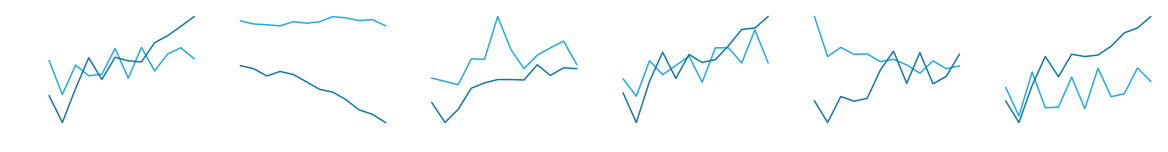

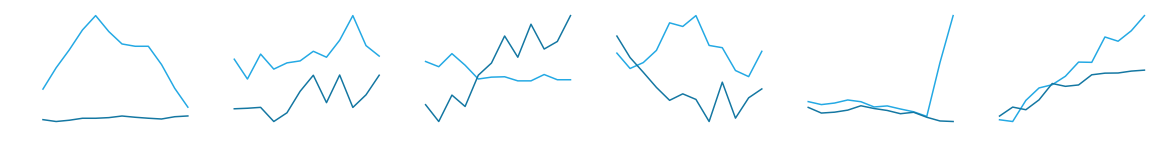

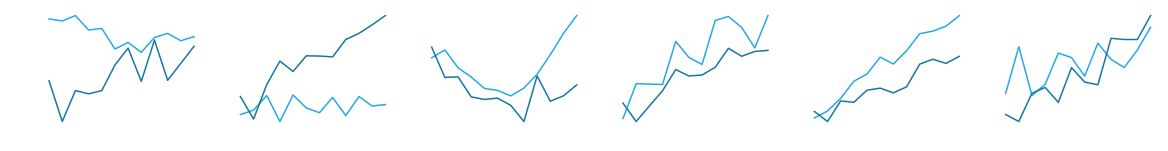

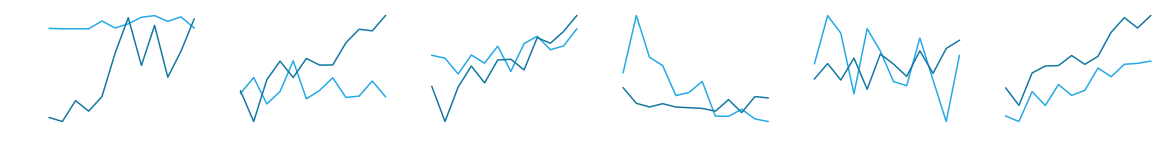

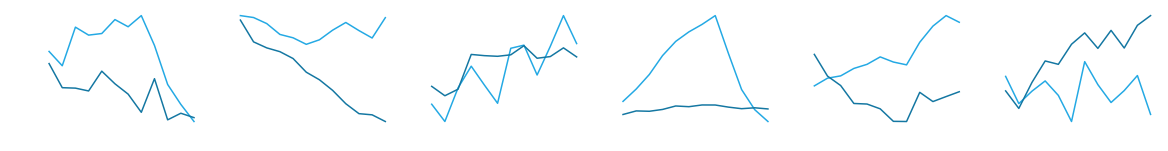

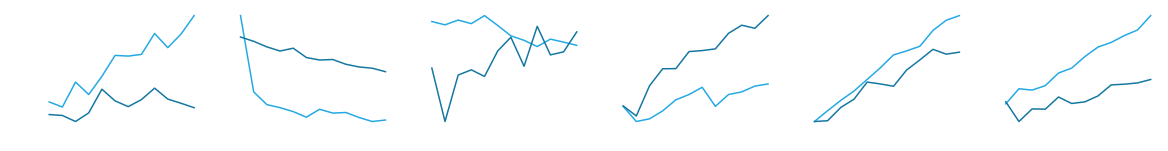

3 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.067370, best: 100000.000
Training Acc: 0.488, Test Acc: 0.493
-24.97930953873622
Epoch:      500/   50000 cost: 0.964334, best: 100000.000
Training Acc: 0.817, Test Acc: 0.702
0.6809939935413295
Epoch:     1000/   50000 cost: 1.272603, best: 100000.000
Training Acc: 0.825, Test Acc: 0.711
0.7000645482159835
Epoch:     1003/   50000 cost: 1.273808, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1084/   50000 cost: 1.323456, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1170/   50000 cost: 1.371516, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1178/   50000 cost: 1.376161, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1186/   50000 cost: 1.381412, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1324/   50000 cost: 1.463942, best: 0.001 *Best value was replaced.
0.7000645482159835
Epoch:     1426/   500

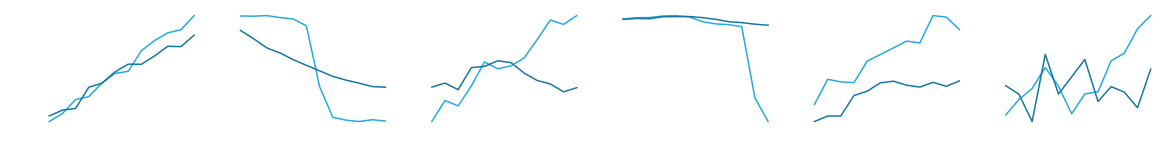

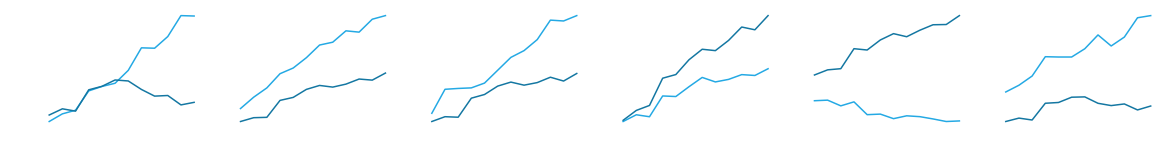

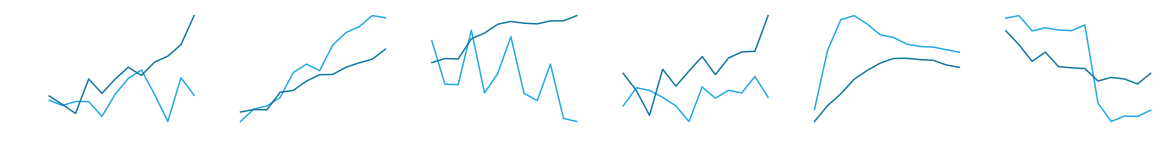

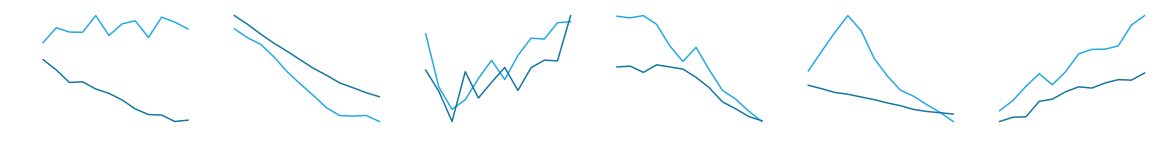

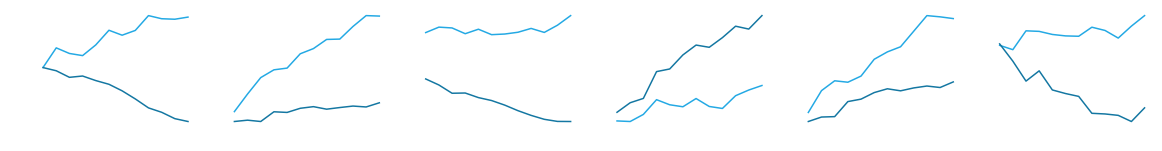

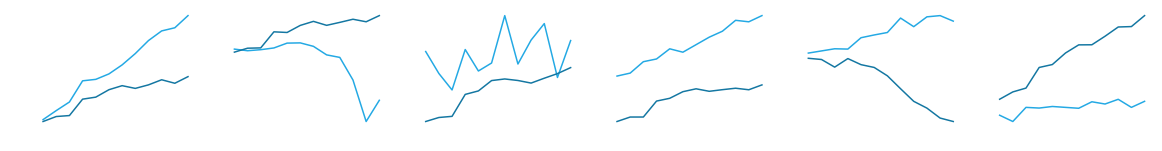

4 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.199701, best: 100000.000
Training Acc: 0.493, Test Acc: 0.497
-89.0664214151097
Epoch:      500/   50000 cost: 2.054343, best: 100000.000
Training Acc: 0.737, Test Acc: 0.511
0.3231045544089357
Epoch:     1001/   50000 cost: 2.441150, best: 0.001 *Best value was replaced.
0.3231045544089357
Epoch:     1000/   50000 cost: 2.441150, best: 0.001
Training Acc: 0.817, Test Acc: 0.610
0.5754946725928315
Epoch:     1003/   50000 cost: 2.442257, best: 0.001 *Best value was replaced.
0.5754946725928315
Epoch:     1004/   50000 cost: 2.443229, best: 0.001 *Best value was replaced.
0.5754946725928315
Epoch:     1010/   50000 cost: 2.447825, best: 0.001 *Best value was replaced.
0.5754946725928315
Epoch:     1057/   50000 cost: 2.478644, best: 0.001 *Best value was replaced.
0.5754946725928315
Epoch:     1058/   50000 cost: 2.479186, best: 0.001 *Best value was replaced.
0.5754946725928315
Epoch:     1067/   50000 cos

Training Acc: 0.883, Test Acc: 0.723
0.6473506475152526
Epoch:     9500/   50000 cost: 7.200875, best: 0.001
Training Acc: 0.876, Test Acc: 0.699
0.6500113239107813
Epoch:    10000/   50000 cost: 7.450754, best: 0.001
Training Acc: 0.871, Test Acc: 0.718
0.6426803144589966
Epoch:    10500/   50000 cost: 7.689649, best: 0.001
Training Acc: 0.859, Test Acc: 0.690
0.6327264648746899
Epoch:    11000/   50000 cost: 7.936526, best: 0.001
Training Acc: 0.864, Test Acc: 0.663
0.5877456213059985
Epoch:    11129/   50000 cost: 8.004650, best: 0.001 *Best value was replaced.
0.5877456213059985
Epoch:    11131/   50000 cost: 8.005700, best: 0.001 *Best value was replaced.
0.5877456213059985
Epoch:    11352/   50000 cost: 8.111221, best: 0.001 *Best value was replaced.
0.5877456213059985
Epoch:    11500/   50000 cost: 8.183853, best: 0.001
Training Acc: 0.871, Test Acc: 0.693
0.630564875861376
Epoch:    11607/   50000 cost: 8.236364, best: 0.001 *Best value was replaced.
0.630564875861376
Epoch:   

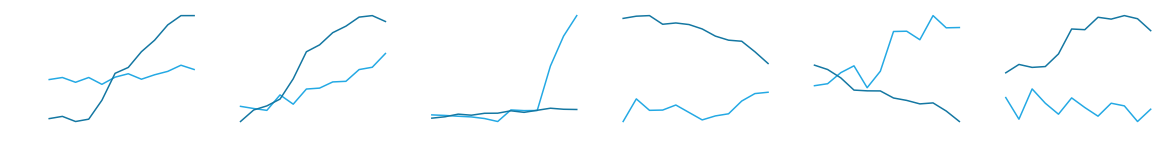

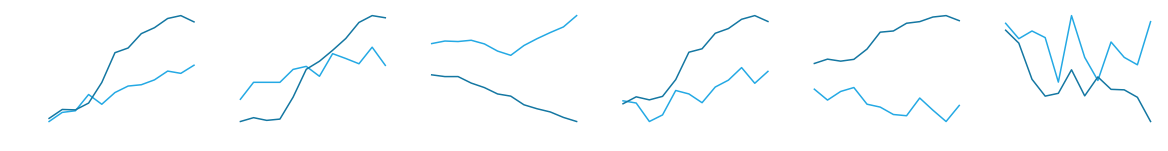

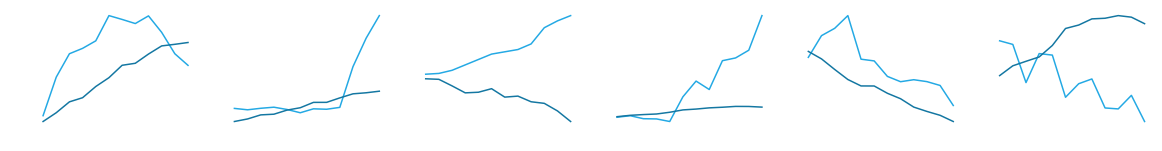

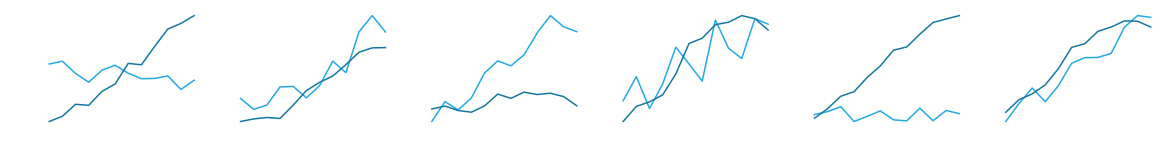

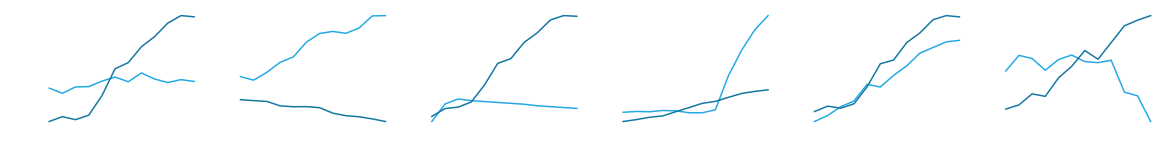

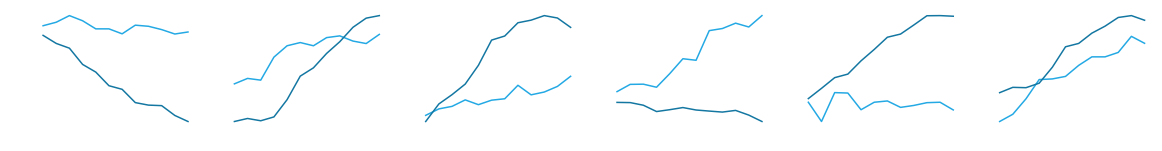

5 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.103284, best: 100000.000
Training Acc: 0.490, Test Acc: 0.497
-74.33130240759768
Epoch:      500/   50000 cost: 1.156335, best: 100000.000
Training Acc: 0.765, Test Acc: 0.721
0.38496031354622834
Epoch:     1001/   50000 cost: 1.608939, best: 0.000 *Best value was replaced.
0.38496031354622834
Epoch:     1000/   50000 cost: 1.608939, best: 0.000
Training Acc: 0.779, Test Acc: 0.782
0.6828936709915284
Epoch:     1002/   50000 cost: 1.609519, best: 0.000 *Best value was replaced.
0.6828936709915284
Epoch:     1006/   50000 cost: 1.612718, best: 0.000 *Best value was replaced.
0.6828936709915284
Epoch:     1009/   50000 cost: 1.615797, best: 0.000 *Best value was replaced.
0.6828936709915284
Epoch:     1010/   50000 cost: 1.616473, best: 0.000 *Best value was replaced.
0.6828936709915284
Epoch:     1032/   50000 cost: 1.635323, best: 0.000 *Best value was replaced.
0.6828936709915284
Epoch:     1040/   50000 

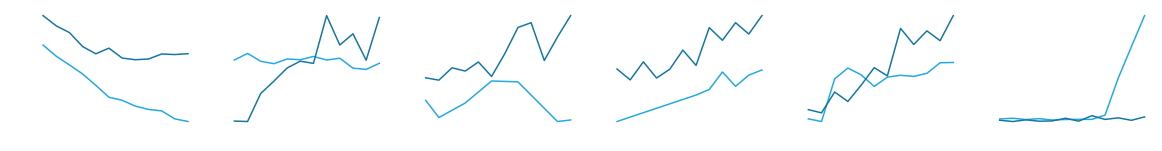

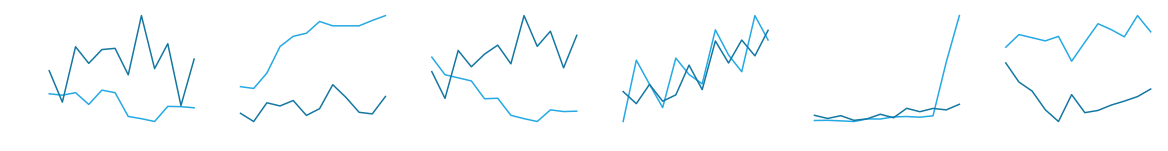

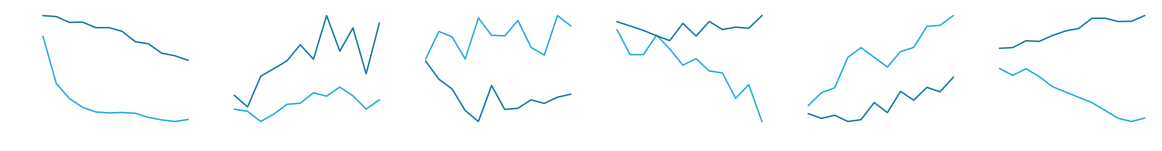

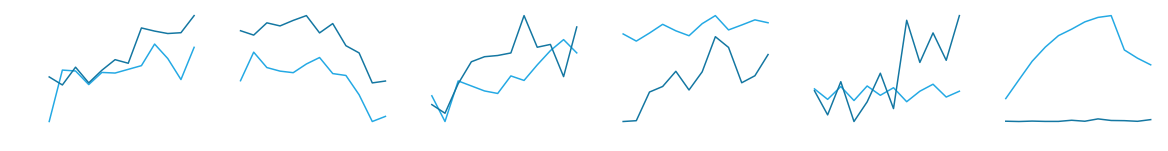

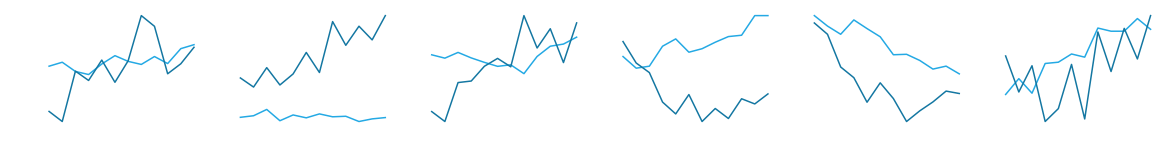

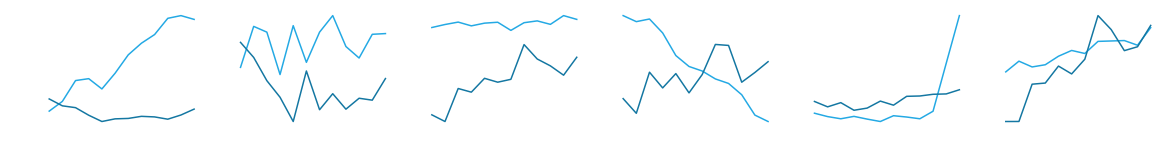

All fold vaildation were ended.
5-fold validation accuracy: 0.773


In [14]:
accuracies = []
for i in range(N_FOLD):
    
    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]

    print("%d for started." % (i+1))
    # Parameters
    EXPLANATION_F = EXPLANATION + "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 999
    
    global_step = tf.Variable(0, trainable=False)    
    LEARNING_RATE = tf.train.exponential_decay(0.035, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.0001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 12
    DROP_PROB = 0.9
    BATCH_SIZE =  512
    DISPLAY_STEP = 500

    N_INPUT = rnn_input[0].shape[1]
    N_OUTPUT = rnn_label[0].shape[0]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    
    # Define weights
    weights = tf.get_variable(EXPLANATION_F[-2:] + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(EXPLANATION_F[-2:] + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)    
    
    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)

        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation

    pred = RNN(x, weights, biases, drop_prob)

    print("networks are ready")
    
    # Define loss and optimizer
    cost =  tf.losses.mean_squared_error(labels=y, predictions=pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon = EPSILON).minimize(cost)
    tf.summary.scalar('cost', cost)
    
    # Evaluate model
    ymean = tf.reduce_mean(y)
    SSE = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    SSR = tf.reduce_sum(tf.square(tf.subtract(pred, ymean)))
    r_squared = SSR/(SSE+SSR)

    accuracy = r_squared
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()
    
    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/open_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/open_" + "F"+ str(i+1))
    sess.run(init)

    print("seesion start")
    
    
    
    # Launch the graph
    best_pred_acc = 100000
    ex_pred_acc = 100000
    avg_cost = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()

    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB})
        train_writer.add_summary(summary, EPOCH)
        avg_cost += sess.run(cost, feed_dict={x: batch_x, y: batch_y, drop_prob: 1.0})
        summary, pred_acc = sess.run([merged, cost], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
        test_writer.add_summary(summary, EPOCH)
        if pred_acc < ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc < best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION_F + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, avg_cost, best_pred_acc))
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc
            
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, avg_cost, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            print(r2_score(pred_label, R2))

    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, avg_cost, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))
    
    
    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION_F + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
    accuracies.append(final_acc)
    print ("Testing Accuracy:", final_acc)
    training_result = sess.run(pred, feed_dict={x: rnn_input, drop_prob: 1.0})
    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0})
    #Chronol
    print("Chronological graphs for fold # %d." % (i+1))
    x_t = np.arange(0, OUTPUT_SIZE)

    for _ in range (6):

        NUMBERS = np.arange(1, prediction.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 661

        for NUMBER in NUMBERS:

            fig = plt.subplot(position)
            measured1 = plt.plot(x_t, pred_label[NUMBER, :], c=cmap_m[5]) #estimated
            expect1 = plt.plot(x_t, prediction[NUMBER, :], c=cmap[5]) #estimated
            fig.axis('off')

            position += 1
        plt.show()
        _ += 1
    training_result = (training_result * (LABELMAXS - LABELMINS)) + LABELMINS
    training_label = (rnn_label * (LABELMAXS - LABELMINS)) + LABELMINS
    prediction = (prediction * (LABELMAXS - LABELMINS)) + LABELMINS
    pred_label = (pred_label * (LABELMAXS - LABELMINS)) + LABELMINS
    training_result_csv = pd.DataFrame(training_result)
    training_label_csv = pd.DataFrame(training_label)
    prediction_csv = pd.DataFrame(prediction, index=pred_label_index[i])
    pred_label_csv = pd.DataFrame(pred_label, index=pred_label_index[i])
    
    if not os.path.isdir("./results/"):
        os.makedir("./results/")
    training_result_csv.to_csv("./results/" + "train_rs" + EXPLANATION_F + ".CSV")
    training_label_csv.to_csv("./results/" + "train_lb" + EXPLANATION_F + ".CSV")
    prediction_csv.to_csv("./results/" + "output_" + EXPLANATION_F + ".CSV")
    pred_label_csv.to_csv("./results/" + "labels_" + EXPLANATION_F + ".CSV")
    
    tf.reset_default_graph()
    sess.close()
    
print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))